
# Malaria Detection

Malaria is a life-threatening disease caused by parasites that are transmitted to people through the bites of infected female Anopheles mosquitoes. It is preventable and curable.

    In 2017, there were an estimated 219 million cases of malaria in 90 countries.
    Malaria deaths reached 435 000 in 2017.
    The WHO African Region carries a disproportionately high share of the global malaria burden. In 2017, the region was home to 92% of malaria cases and 93% of malaria deaths.

Malaria is caused by Plasmodium parasites. The parasites are spread to people through the bites of infected female Anopheles mosquitoes, called *"malaria vectors."* There are 5 parasite species that cause malaria in humans, and 2 of these species – P. falciparum and P. vivax – pose the greatest threat.

**Diagnosis of malaria can be difficult:**

    Where malaria is not endemic any more (such as in the United States), health-care providers may not be familiar with the disease. Clinicians seeing a malaria patient may forget to consider malaria among the potential diagnoses and not order the needed diagnostic tests. Laboratorians may lack experience with malaria and fail to detect parasites when examining blood smears under the microscope.
    Malaria is an acute febrile illness. In a non-immune individual, symptoms usually appear 10–15 days after the infective mosquito bite. The first symptoms – fever, headache, and chills – may be mild and difficult to recognize as malaria. If not treated within 24 hours, P. falciparum malaria can progress to severe illness, often leading to death.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

import os
print(os.listdir("../input/cell-images-for-detecting-malaria/cell_images/cell_images/"))

['Uninfected', 'Parasitized']


**Dataset**

In [2]:
img_dir='../input/cell-images-for-detecting-malaria/cell_images/cell_images/'

In [3]:
path=Path(img_dir)
path

PosixPath('../input/cell-images-for-detecting-malaria/cell_images/cell_images')

In [4]:
data = ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [5]:
print(f'Classes: \n {data.classes}')

Classes: 
 ['Parasitized', 'Uninfected']


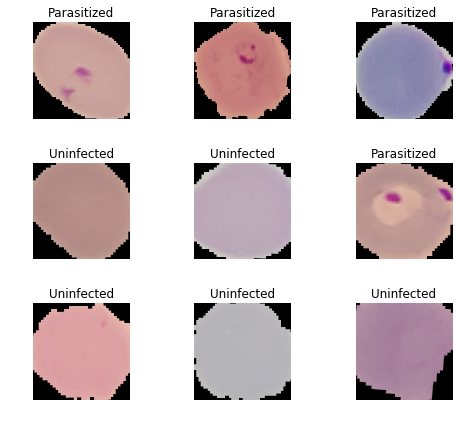

In [6]:
data.show_batch(rows=3, figsize=(7,6))

## Model ResNet34

In [7]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:36<00:00, 2.37MB/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


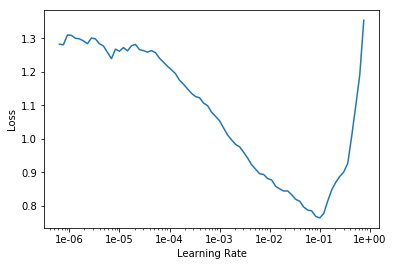

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(6,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.174793,0.164136,0.950281,05:03
1,0.184290,0.191201,0.943930,03:37
2,0.148714,0.121128,0.961169,03:36
3,0.128353,0.105873,0.961531,03:35
4,0.113488,0.086133,0.967520,03:33
5,0.105678,0.085110,0.968790,03:36


In [10]:
learn.save('stage-2')

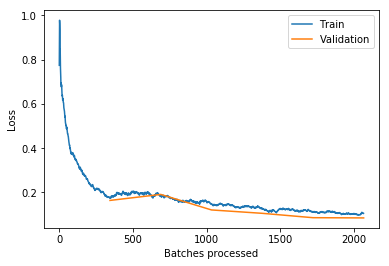

In [11]:
learn.recorder.plot_losses()

In [12]:
interp = ClassificationInterpretation.from_learner(learn)

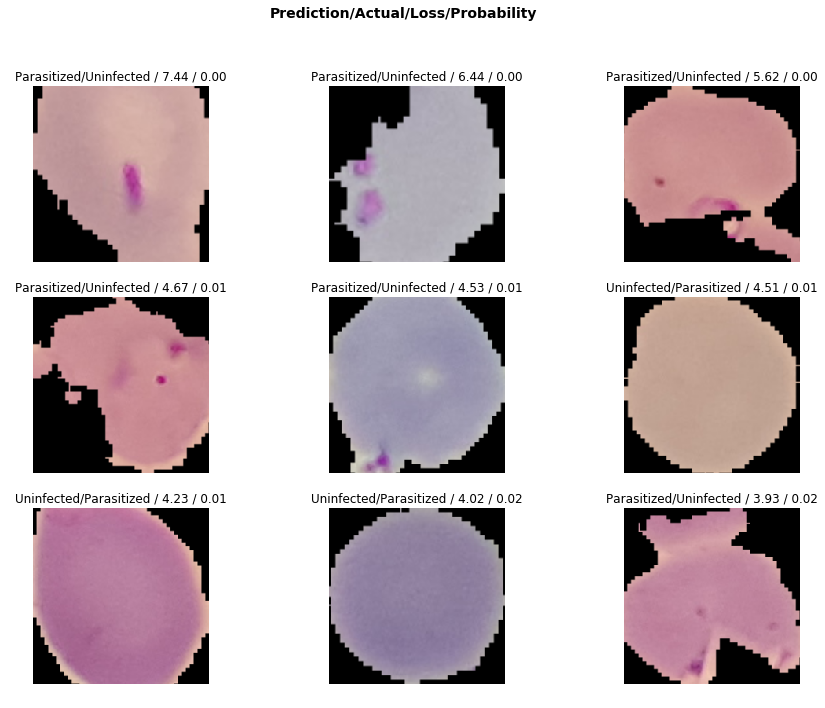

In [13]:
interp.plot_top_losses(9, figsize=(15,11))

**Confusion Matrix**

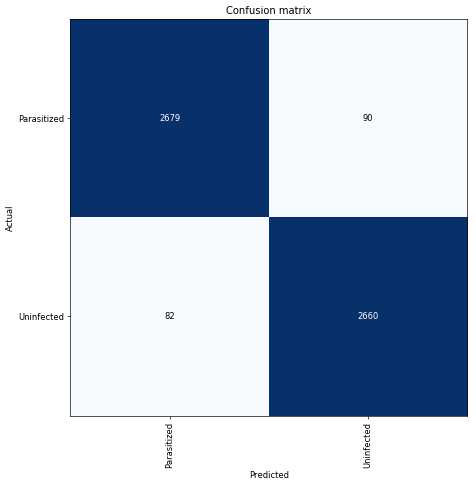

In [14]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [15]:
interp.most_confused(min_val=2)

[('Parasitized', 'Uninfected', 90), ('Uninfected', 'Parasitized', 82)]

In [16]:
pred_data= ImageDataBunch.from_folder(path, train=".", 
                                  valid_pct=0.2,
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)

In [17]:
predictor=cnn_learner(data, models.resnet34, metrics=accuracy, model_dir="/tmp/model/").load('stage-2')

In [18]:
pred_data.single_from_classes(path, pred_data.classes)

ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../input/cell-images-for-detecting-malaria/cell_images/cell_images;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: ../input/cell-images-for-detecting-malaria/cell_images/cell_images;

Test: None

Category Parasitized

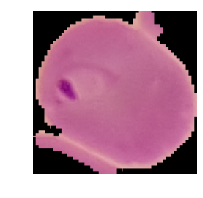

In [19]:
x,y = data.valid_ds[3]
x.show()
data.valid_ds.y[3]

In [20]:
pred_class,pred_idx,outputs = predictor.predict(x)
pred_class

Category Parasitized

## Heatmaps
**The heatmap will help us identify were our model it's looking and it's really useful for decision making**

In [21]:
def heatMap(x,y,data, learner, size=(0,224,224,0)):
    """HeatMap"""
    
    # Evaluation mode
    m=learner.model.eval()
    
    # Denormalize the image
    xb,_ = data.one_item(x)
    xb_im = Image(data.denorm(xb)[0])
    xb = xb.cuda()
    
    # hook the activations
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()

    # Activations    
    acts=hook_a.stored[0].cpu()
    
    # Avg of the activations
    avg_acts=acts.mean(0)
    
    # Show HeatMap
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(avg_acts, alpha=0.5, extent=size,
              interpolation='bilinear', cmap='magma')

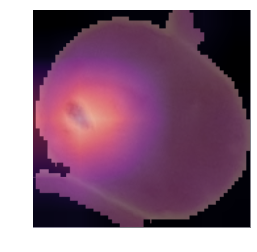

In [22]:
heatMap(x,y,pred_data,learn)

***It is very hard to completely eliminate false positives and negatives (in a case like this, it could indicate overfitting, given the relatively small training dataset), but the metric for the suitability of a model for the real world is how the model's sensitivity and specificity compare to that of a group of actual pathologists with domain expertise, when both analyze an identical set of real world data that neither has prior exposure to.***

You might improve the accuracy if you artificially increase the size of the training dataset by changing orientations, mirroring, etc., assuming the orientation of the NIH images of the smears haven't been normalized (I would assume they haven't, but that's a dangerous assumption). I'm also curious if you compared ResNet-34 and -50, as 50 might help your specificity (or not).*